In [1]:
# Uncomment this block to install necessary dependencies.
# !pip install xgboost
# !pip install hyperopt
# !pip install statsmodels
# !pip install -U -q keras-tuner

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
#@title Imports
import gc
import tqdm
import IPython
import imageio
import datetime
import numpy as np
import xgboost as xgb
import pandas as pd
import pickle as pkl
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
import matplotlib.pyplot as plt

from time import sleep
from collections import defaultdict
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL

from dataset import windowed_dataset, series_transformer
from utils import ts_analysis_plots, copy_and_modify_dict
from utils import plot_serie_with_next_window_prediction, predict_and_plot_next_window_from_date
from models.xgboost import train_xgb, optimize_xgb, optimize_direct_xgb, mape, load_direct_model

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)
tf.random.set_seed(seed)

# A nivel de Países

Leer datos de todas las series temporales sobre covid y consultar solo valores de interes (paises y variables)

In [3]:
data = pd.read_excel('data/owid-covid-data.xlsx')

timeline = sorted(np.unique(data.date.astype('datetime64[ns]')))
data_selected = data.loc[
    (~data.iso_code.isna()) & (data.iso_code != 'OWID_WRL'), [
        'iso_code', 'continent', 'location', 'date', 'new_cases',
        'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed'
    ]]

data_selected.head()

,iso_code,continent,location,date,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed
0,AFG,Asia,Afghanistan,2019-12-31,0.0,NaN,0.0,NaN
1,AFG,Asia,Afghanistan,2020-01-01,0.0,NaN,0.0,NaN
2,AFG,Asia,Afghanistan,2020-01-02,0.0,NaN,0.0,NaN
3,AFG,Asia,Afghanistan,2020-01-03,0.0,NaN,0.0,NaN
4,AFG,Asia,Afghanistan,2020-01-04,0.0,NaN,0.0,NaN


Analizar la cantidad de registros por cada país y agruparlos por cantidad y analizar los registros por cada país y seleccionar los países que tengan el mismo numero de mayor registros

In [4]:
country_freq = data_selected.groupby(['location']).agg({
    'date': 'count'
}).rename(columns={'date': 'num_records'})

records, counts = np.unique(country_freq.num_records.values,
                            return_counts=True)

print('Max group of records {}'.format(max(counts)))
print('Order by num of records {}'.format(
    list(
        zip(records[np.argsort(counts)][::-1],
            counts[np.argsort(counts)][::-1]))))

Max group of records 63
Order by num of records [(306, 63), (231, 12), (226, 11), (232, 8), (225, 8), (227, 7), (228, 7), (233, 6), (224, 5), (236, 5), (235, 4), (240, 4), (229, 4), (238, 4), (239, 4), (223, 4), (219, 3), (214, 3), (237, 3), (242, 3), (230, 3), (247, 2), (249, 2), (221, 2), (220, 2), (305, 2), (241, 2), (234, 2), (222, 2), (268, 2), (189, 1), (206, 1), (205, 1), (250, 1), (184, 1), (183, 1), (211, 1), (170, 1), (58, 1), (16, 1), (15, 1), (209, 1), (304, 1), (213, 1), (215, 1), (217, 1), (218, 1), (276, 1), (269, 1), (258, 1), (243, 1), (244, 1), (245, 1), (3, 1)]


Armar la estructura para casos nuevos y hacer padding a cada lista del dict # 294 es el maximo

In [5]:
data_to_use = defaultdict(list)
# use data tem to less countries
for index, row in data_selected.iterrows():
    # new_cases_smoothed.
    data_to_use[row.location].append(row.new_cases_smoothed)

final_dict = dict()
for country in data_to_use.keys():
    diff = 306 - len(data_to_use[country])
    final_dict[country] = [0.0] * diff + data_to_use[country]

del data_to_use
data_to_use = pd.DataFrame(final_dict)
data_to_use['date'] = timeline
data_to_use.set_index('date', inplace=True)
data_to_use.fillna(axis=0, method='backfill', inplace=True)

data_to_use

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-01,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-02,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-03,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
2020-01-04,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,106.429,299.286,257.571,100.286,251.286,0.0,0.714,14234.143,2135.714,12.286,...,44.571,289.714,0.0,487.286,4.143,0.0,0.0,0.571,43.286,20.571
2020-10-28,110.000,296.857,266.714,112.429,259.286,0.0,0.714,13944.286,2279.571,9.286,...,41.857,289.571,0.0,393.714,4.429,0.0,0.0,0.571,37.286,18.286
2020-10-29,90.714,298.857,276.429,100.857,260.286,0.0,0.286,13315.429,2357.714,9.714,...,45.429,282.571,0.0,405.857,4.000,0.0,0.0,0.429,46.429,15.000


# Selección de países

Quitar Colombia de la lista

In [6]:
contries_top = data_to_use.keys()[(data_to_use.sum() >=
                                   184000).values].values.tolist()
contries_top.pop(contries_top.index('Colombia'))

'Colombia'

## Leer datos de Colombia

In [7]:
data_colombia = pd.read_csv('data/Casos_positivos_de_COVID-19_en_Colombia.csv')
data_colombia.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fecha reporte web,ID de caso,Fecha de notificación,Código DIVIPOLA departamento,Nombre departamento,Código DIVIPOLA municipio,Nombre municipio,Edad,Unidad de medida de edad,Sexo,...,Código ISO del país,Nombre del país,Recuperado,Fecha de inicio de síntomas,Fecha de muerte,Fecha de diagnóstico,Fecha de recuperación,Tipo de recuperación,Pertenencia étnica,Nombre del grupo étnico
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,...,380.0,ITALIA,Recuperado,27/2/2020 0:00:00,NaN,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6.0,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,...,724.0,ESPAÑA,Recuperado,4/3/2020 0:00:00,NaN,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5.0,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,...,724.0,ESPAÑA,Recuperado,29/2/2020 0:00:00,NaN,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6.0,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,...,NaN,NaN,Recuperado,6/3/2020 0:00:00,NaN,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6.0,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,...,NaN,NaN,Recuperado,8/3/2020 0:00:00,NaN,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6.0,NaN


Encontrar numero de casos por departamento y solo tomo los departamentos mayores al promedio

In [8]:
df_freq_dep = data_colombia.groupby([
    'Nombre departamento'
]).count()['Fecha de notificación'].to_frame().rename(
    columns={'Fecha de notificación': 'Casos'})

departamentos_iniciales = df_freq_dep.loc[
    df_freq_dep.Casos > df_freq_dep.Casos.mean()].index.values.tolist()

departamentos_iniciales.pop(departamentos_iniciales.index('BARRANQUILLA'))
departamentos_iniciales.pop(departamentos_iniciales.index('BOGOTA'))

departamentos_iniciales

['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']

Encontrar numero de casos por ciudad

In [9]:
df_freq = data_colombia.groupby(
    ['Nombre municipio']).count()['Fecha de notificación'].to_frame().rename(
        columns={'Fecha de notificación': 'Casos'})

Solo tomar los que tiene mas casos que Bucaramanga

In [10]:
ciudades_iniciales = df_freq.loc[df_freq.Casos >= df_freq.loc[
    df_freq.index == 'BUCARAMANGA'].values[0][0]].index.values.tolist()

data_colombia_main_ciudades = data_colombia.loc[
    data_colombia['Nombre municipio'].isin(ciudades_iniciales)].groupby(
        ['Nombre municipio', 'Fecha de notificación']).agg({
            'Fecha de notificación':
            'count'
        }).rename(columns={'Fecha de notificación': 'cases'})

data_colombia_main_dep = data_colombia.loc[(
    data_colombia['Nombre departamento'].isin(departamentos_iniciales)
)].groupby(['Nombre departamento', 'Fecha de notificación']).agg({
    'Fecha de notificación':
    'count'
}).rename(columns={'Fecha de notificación': 'cases'})

data_colombia_main_dep

cases
Nombre departamento Fecha de notificación       
ANTIOQUIA           1/10/2020 0:00:00       1541
                    1/4/2020 0:00:00           9
                    1/5/2020 0:00:00           5
                    1/6/2020 0:00:00          60
                    1/7/2020 0:00:00         493
...                                          ...
VALLE               9/5/2020 0:00:00          65
                    9/6/2020 0:00:00         296
                    9/7/2020 0:00:00         517
                    9/8/2020 0:00:00         272
                    9/9/2020 0:00:00         541

[1105 rows x 1 columns]

In [11]:
data_colombia_main_ciudades = data_colombia_main_ciudades.cases.unstack(
).T.fillna(axis=0, method='backfill', inplace=False)
data_colombia_main_dep = data_colombia_main_dep.cases.unstack().T.fillna(
    axis=0, method='backfill', inplace=False)
data_colombia_main = data_colombia_main_ciudades.join(data_colombia_main_dep)

data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
Fecha de notificación,,,,,,,,,,,
1/10/2020 0:00:00,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
1/4/2020 0:00:00,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
1/5/2020 0:00:00,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
1/6/2020 0:00:00,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
1/7/2020 0:00:00,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
9/5/2020 0:00:00,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
9/6/2020 0:00:00,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
9/7/2020 0:00:00,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


In [12]:
#data_colombia_main['date'] = data_colombia_main.index.astype('datetime64[ns]')
data_colombia_main['date'] = pd.to_datetime(data_colombia_main.index,
                                            infer_datetime_format=False,
                                            format='%d/%m/%Y %H:%M:%S')
data_colombia_main.set_index('date', inplace=True)
data_colombia_main

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE
date,,,,,,,,,,,
2020-10-01,59.0,2004.0,122.0,430.0,48.0,907.0,1541.0,47.0,222.0,363.0,638.0
2020-04-01,8.0,113.0,4.0,24.0,4.0,6.0,9.0,2.0,7.0,15.0,26.0
2020-05-01,42.0,129.0,4.0,16.0,20.0,3.0,5.0,79.0,2.0,15.0,17.0
2020-06-01,321.0,489.0,4.0,144.0,104.0,23.0,60.0,192.0,71.0,15.0,242.0
2020-07-01,682.0,2177.0,7.0,432.0,392.0,250.0,493.0,500.0,237.0,48.0,574.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,59.0,210.0,4.0,44.0,74.0,4.0,7.0,96.0,10.0,24.0,65.0
2020-06-09,494.0,591.0,4.0,235.0,175.0,39.0,83.0,287.0,74.0,24.0,296.0
2020-07-09,439.0,2205.0,50.0,424.0,268.0,775.0,1265.0,368.0,266.0,103.0,517.0


## Sincronización de secuencias

Unir los datos de todas las series

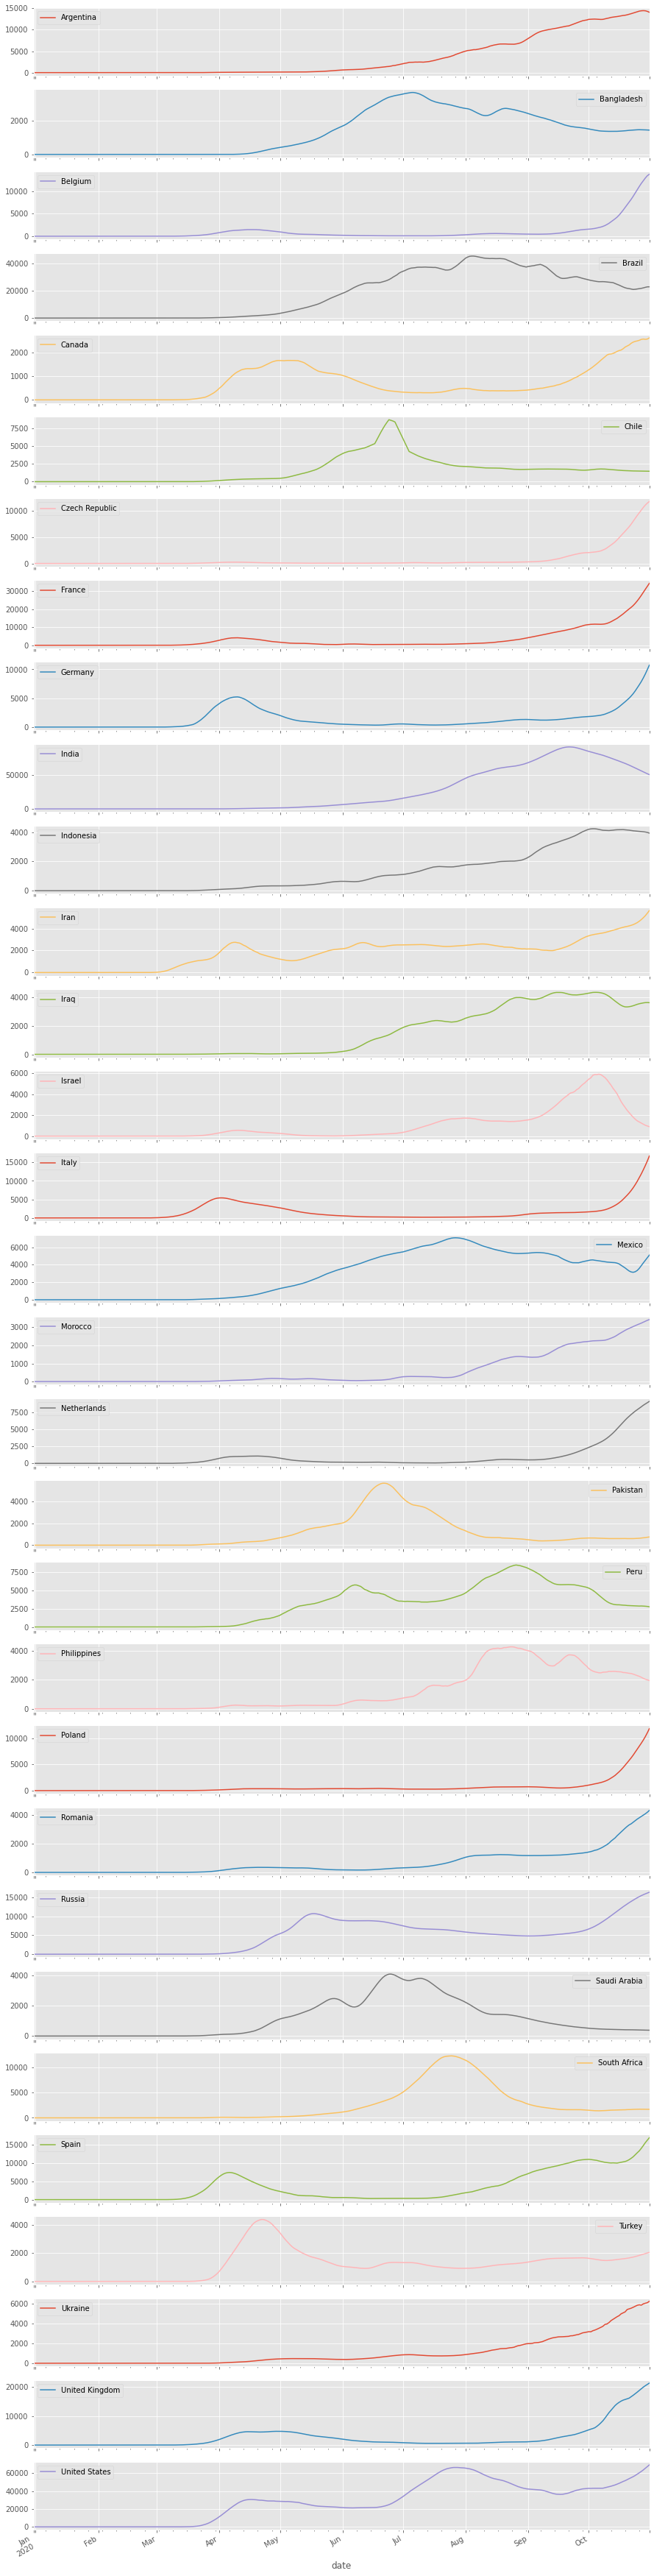

In [13]:
smooth = 10
df_join = data_to_use[contries_top].join(data_colombia_main)

df_join[contries_top].iloc[:, :].rolling(smooth).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=True,
                                                   figsize=(15, 70));

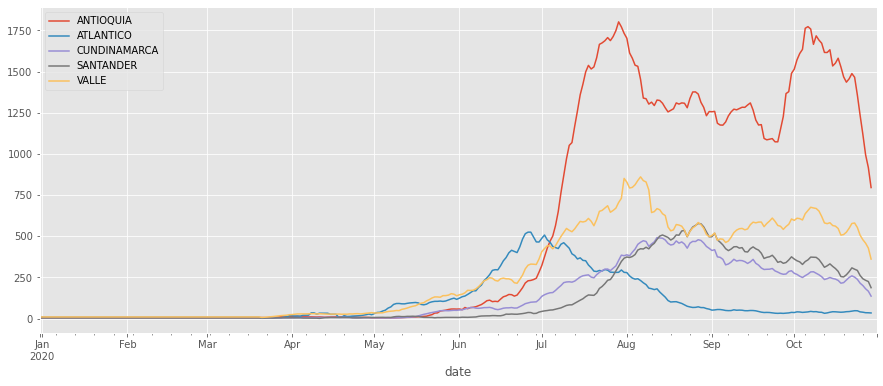

In [14]:
df_join[departamentos_iniciales].rolling(smooth).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(figsize=(15, 6));

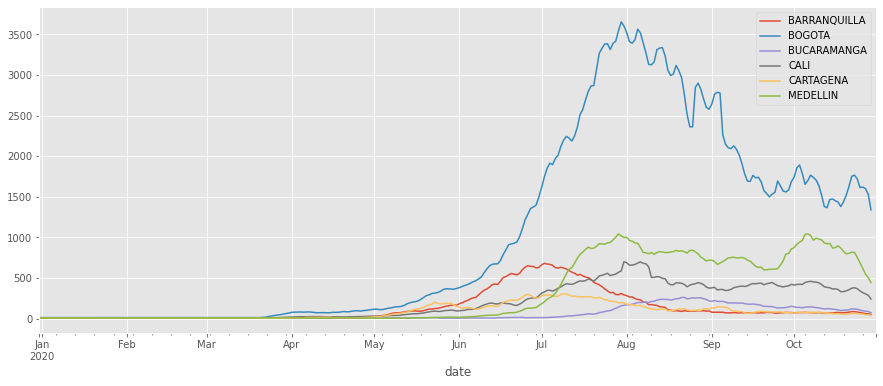

In [15]:
df_join[ciudades_iniciales].rolling(smooth).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(figsize=(15, 6));

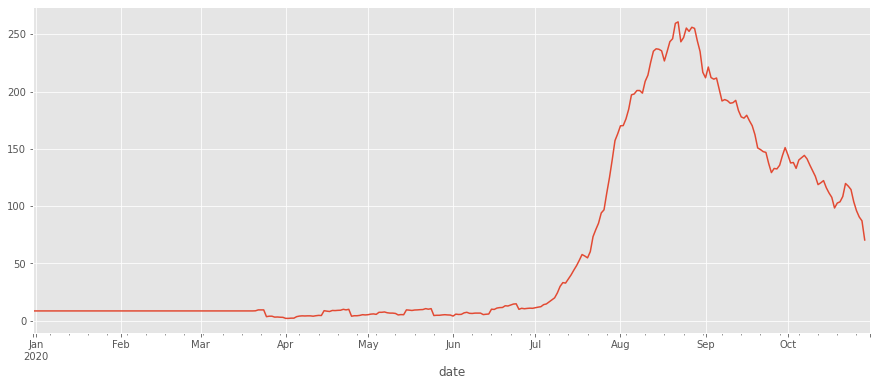

In [16]:
df_join['BUCARAMANGA'].rolling(smooth).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(figsize=(15, 6));

# Análitica inicial 

Parametros compartidos

In [17]:
SCALE = False  # Estandarizar las series temporales.
WINDOW_SIZE = 21  # Tamaño de la ventana.
BATCH_SIZE = 1  # Número de batches.
FUTURE_STEPS = 14  # Número de días a predecir.
SHUFFLE_BUFFER = 10000 # Tamaño del buffer.
stateful = False  # Usar stateful en los modelos.
differentiation, lag = False, 1  # Diferenciar las series con un determinado lag.
smoothing, smooth = False, 7  # Suavizar las series temporales.

# Rango de fechas para seleccionar las series.
initial_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
final_date = datetime.datetime.strptime('2020-10-29', '%Y-%m-%d')

# Rango de fechas para entrenar y testear (última ventana futura más 7 días).
train_final_date = datetime.datetime.strptime('2020-09-18', '%Y-%m-%d')

# Diccionario con parametros basicos para los conjuntos de datos.
base_dset_params = dict(batch_size=BATCH_SIZE,
                        past_window=WINDOW_SIZE,
                        future_window=FUTURE_STEPS,
                        shuffle_buffer=SHUFFLE_BUFFER,
                        col_test_series=0)

Graphs

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


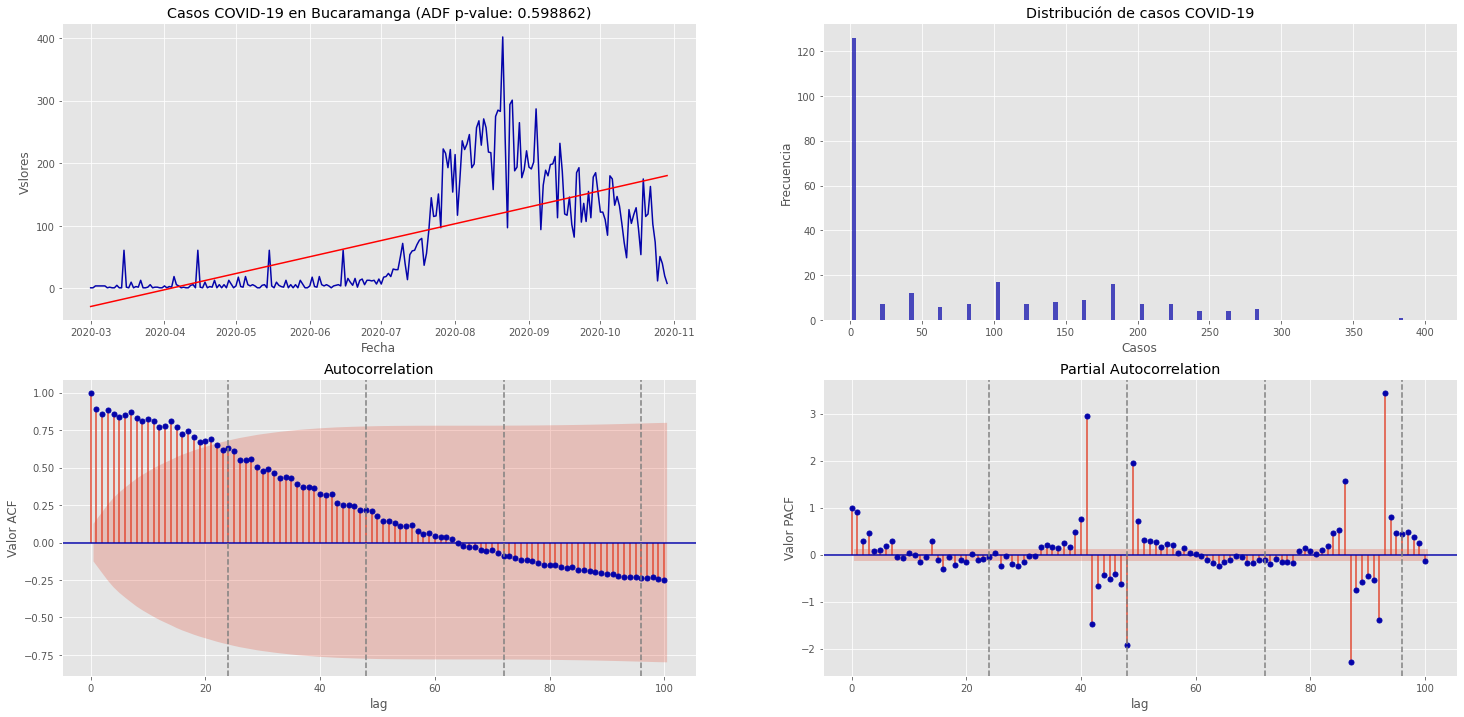

In [18]:
serie_bucaramanga = df_join.loc[(df_join.index >= initial_date) & (
    df_join.index <= final_date), 'BUCARAMANGA'].fillna(axis=0,
                                                        method='backfill',
                                                        inplace=False)
ts_analysis_plots(serie_bucaramanga)

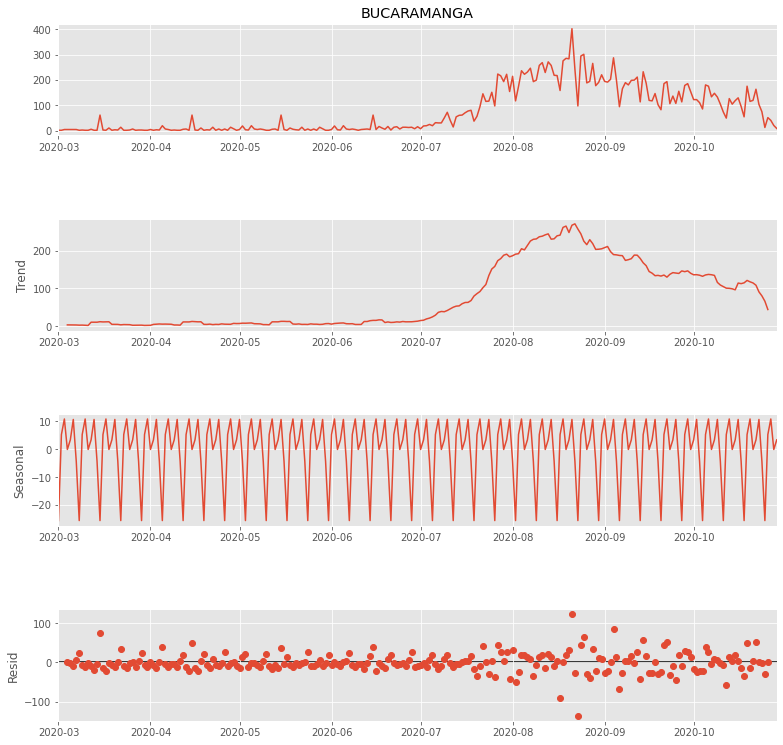

In [19]:
res = seasonal_decompose(serie_bucaramanga, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))

# Modelos de aprendizaje de máquina clasicos

## Conjunto de datos

In [20]:
final_data = df_join.loc[(df_join.index >= initial_date)
                         & (df_join.index <= final_date)]
final_data_train = final_data.loc[final_data.index <= train_final_date]
final_data_test = final_data.loc[final_data.index > train_final_date]

bga_data_train, bga_scaler = series_transformer(
    final_data_train['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=None)

bga_data_test, bga_scaler = series_transformer(
    final_data_test['BUCARAMANGA'].to_frame(),
    standarization=True,
    scaler=bga_scaler)

### Enfoque directo

In [21]:
ml_direct_train_dset_params = copy_and_modify_dict(base_dset_params, {})
ml_direct_test_dset_params = copy_and_modify_dict(base_dset_params,
                                                  {'shuffle_buffer': 0})

ml_direct_bga_dset_train = windowed_dataset(bga_data_train,
                                            ml_direct_train_dset_params,
                                            tf_dset=False,
                                            direct_dset=True)

ml_direct_bga_dset_test = windowed_dataset(bga_data_test,
                                           ml_direct_test_dset_params,
                                           tf_dset=False,
                                           direct_dset=True)

### Enfoque recursivo

In [22]:
ml_rec_train_dset_params = copy_and_modify_dict(base_dset_params,
                                                {'future_window': 1})
ml_rec_test_dset_params = copy_and_modify_dict(base_dset_params, {
    'shuffle_buffer': 0,
    'future_window': 1
})

ml_rec_bga_dset_train = windowed_dataset(bga_data_train,
                                         ml_rec_train_dset_params,
                                         tf_dset=False,
                                         direct_dset=False)

ml_rec_bga_dset_test = windowed_dataset(bga_data_test,
                                        ml_rec_test_dset_params,
                                        tf_dset=False,
                                        direct_dset=False)

## Models definition and training

### SVR Recursive - Bucaramanga

In [23]:
from sklearn.svm import SVR
from sklearn import metrics
import shutil
svr_rec_dir = 'trained_models/svr_recursive/'
if os.path.exists(svr_rec_dir): shutil.rmtree(svr_rec_dir)
os.makedirs(svr_rec_dir, exist_ok=True)

scoring = metrics.make_scorer(metrics.mean_squared_error)
def build_model(hp):

    model = SVR(kernel=hp.Choice(
        'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
                degree=hp.Int('degree', 1, 10, step=1),
                gamma=hp.Choice('gamma', ['scale', 'auto']),
                coef0=hp.Float('coef0', 1e-3, 1, sampling='log'),
                C=hp.Float('C', 1e-3, 1, sampling='log'),
                epsilon=hp.Float('epsilon', 1e-3, 1e-1, sampling='log'))
    return model


tuner = kt.tuners.Sklearn(oracle=kt.oracles.BayesianOptimization(
    objective=kt.Objective('score', 'min'), max_trials=50),
                          hypermodel=build_model, directory=svr_rec_dir, scoring=scoring)

tuner.search(ml_rec_bga_dset_train['x'], ml_rec_bga_dset_train['y'])

INFO:tensorflow:Oracle triggered exit


In [24]:
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])

test_score = mape(ml_rec_bga_dset_test['y'], svr_preds_rec)
test_score = metrics.mean_absolute_error(ml_rec_bga_dset_test['y'], svr_preds_rec)
print(
    f"Mean absolute error test: {test_score:.4f}"
)

Mean absolute error test: 0.4108


Save model

In [25]:
with open('trained_models/svr_recursive.pkl', 'wb') as pickle_file:
    pkl.dump(best_model, pickle_file, protocol=pkl.HIGHEST_PROTOCOL)

Load to test if it gives the same predictions

In [26]:
with open('trained_models/svr_recursive.pkl', 'rb') as pickle_file:
    svr_rec_test = pkl.load(pickle_file)

In [27]:
svr_preds_rec = best_model.predict(ml_rec_bga_dset_test['x'])
svr_preds_test = svr_rec_test.predict(ml_rec_bga_dset_test['x'])
np.array_equal(svr_preds_rec, svr_preds_test)

True

Plots

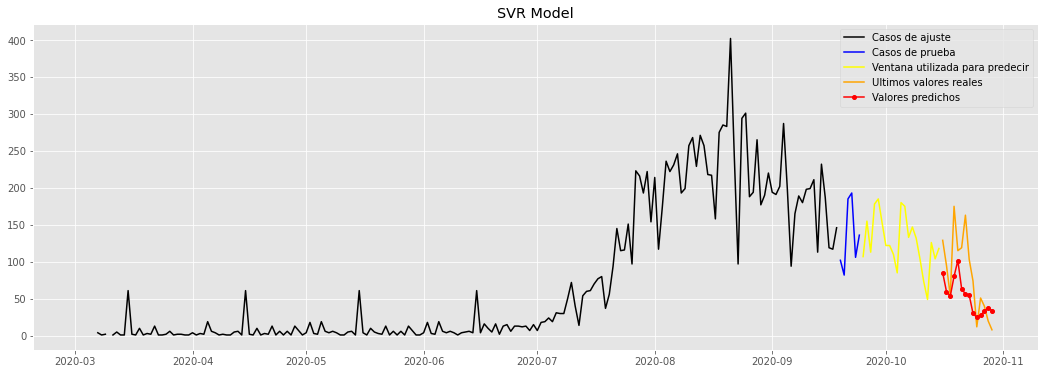

In [28]:
plot_serie_with_next_window_prediction(svr_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       WINDOW_SIZE,
                                       FUTURE_STEPS,
                                       recursive=True,
                                       title='SVR Model')

### 3. XGBoost  Direct - Bucaramanga

Find the best params

In [35]:
xgb_dir_params, xgb_dir_trials = optimize_direct_xgb(
    ml_direct_bga_dset_train['x'], ml_direct_bga_dset_train['y'], max_evals=50)

Optimizing XGBoosts models using a direct approach...
Finding best params for XGBoost model 0...
100%|██████████| 50/50 [02:04<00:00,  2.48s/trial, best loss: 0.37404279707114924]

    Best parameters:
        learning_rate: 0.7412100524801484 
        n_estimators: 470.0
        max_depth: 4.0
        sub_sample: 0.815328356264296
        gamma: 92.0
    
Finding best params for XGBoost model 1...
100%|██████████| 50/50 [02:35<00:00,  3.11s/trial, best loss: 0.508857743893784]

    Best parameters:
        learning_rate: 0.3057979489167077 
        n_estimators: 470.0
        max_depth: 3.0
        sub_sample: 0.9167189358156339
        gamma: 64.0
    
Finding best params for XGBoost model 2...
100%|██████████| 50/50 [02:21<00:00,  2.83s/trial, best loss: 0.5668378980084452]

    Best parameters:
        learning_rate: 0.01087280903917202 
        n_estimators: 660.0
        max_depth: 2.0
        sub_sample: 0.9999692142031118
        gamma: 24.0
    
Finding best params for XGBoost

Use the best params to train the best Direct XGBoost

In [40]:
xgb_dir_results = []
for idx, xgb_dir_param in enumerate(xgb_dir_params):
    xgb_dir_results.append(train_xgb(xgb_dir_param, ml_direct_bga_dset_train['x'][idx], 
                                     ml_direct_bga_dset_train['y'][idx]))

Compute the Root Mean Square Error

In [45]:
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    cv_score = min([
        f["loss"] for f in xgb_dir_trials[idx].results if f["status"] == STATUS_OK
    ])
    test_score = mape(ml_direct_bga_dset_test['y'][idx], xgb_preds_dir)

    print(
        f"Direct Model {idx + 1}: Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
    )

Direct Model 1: Root mean square error cross-validation/test: 0.3740 / 7.6254
Direct Model 2: Root mean square error cross-validation/test: 0.5089 / 7.2830
Direct Model 3: Root mean square error cross-validation/test: 0.5668 / 3.4940
Direct Model 4: Root mean square error cross-validation/test: 0.5883 / 2.1974
Direct Model 5: Root mean square error cross-validation/test: 0.3495 / 2.3473
Direct Model 6: Root mean square error cross-validation/test: 0.7796 / 1.8698
Direct Model 7: Root mean square error cross-validation/test: 0.4086 / 2.8897
Direct Model 8: Root mean square error cross-validation/test: 0.5480 / 3.0682
Direct Model 9: Root mean square error cross-validation/test: 0.6715 / 5.7421
Direct Model 10: Root mean square error cross-validation/test: 0.3997 / 4.5900
Direct Model 11: Root mean square error cross-validation/test: 0.4570 / 6.5007
Direct Model 12: Root mean square error cross-validation/test: 0.4092 / 6.3335
Direct Model 13: Root mean square error cross-validation/test

Save models

In [46]:
os.makedirs('trained_models/xgb_direct/', exist_ok=True)
for idx, xgb_dir_res in enumerate(xgb_dir_results):
    xgb_model_dir = xgb_dir_res["model"]
    xgb_model_dir.save_model(f'trained_models/xgb_direct/xgb_direct_{idx}')

Load and tests if all models give the same results

In [48]:
for idx, xgb_dir_res in enumerate(xgb_dir_results):

    # Load the trained and saved models.
    xgb_dir_test = xgb.XGBRegressor()
    xgb_dir_test.load_model(f'trained_models/xgb_direct/xgb_direct_{idx}')

    # Compare predictions
    xgb_model_dir = xgb_dir_res["model"]
    xgb_preds_dir = xgb_model_dir.predict(ml_direct_bga_dset_test['x'][idx])
    xgb_preds_test = xgb_dir_test.predict(ml_direct_bga_dset_test['x'][idx])
    print('Predictions are equal:',
          np.array_equal(xgb_preds_dir, xgb_preds_test))

Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True
Predictions are equal: True


In [25]:
xgb_direct_models = load_direct_model('trained_models/xgb_direct/')

Plots

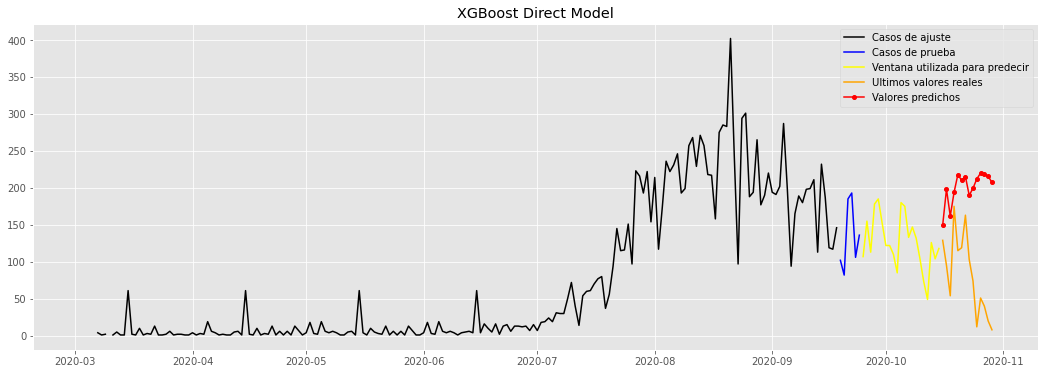

In [26]:
plot_serie_with_next_window_prediction(xgb_direct_models,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       WINDOW_SIZE,
                                       FUTURE_STEPS,
                                       recursive=False,
                                       title='XGBoost Direct Model')

### 4. XGBoost Recursive - Bucaramanga

Find the best params for the Recursive XGBoost approach and train with them.

In [24]:
xgb_rec_params, xgb_rec_trials = optimize_xgb(ml_rec_bga_dset_train['x'],
                                              ml_rec_bga_dset_train['y'],
                                              max_evals=50)

xgb_rec_res = train_xgb(xgb_rec_params, ml_rec_bga_dset_test['x'],
                        ml_rec_bga_dset_test['y'])

100%|██████████| 50/50 [03:21<00:00,  4.03s/trial, best loss: 0.12635602078536534]

    Best parameters:
        learning_rate: 0.080939486390144 
        n_estimators: 780.0
        max_depth: 2.0
        sub_sample: 0.8970804517007905
        gamma: 13.0
    


Compute the Root Mean Square Error

In [26]:
xgb_model_rec = xgb_rec_res["model"]
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
cv_score = min(
    [f["loss"] for f in xgb_rec_trials.results if f["status"] == STATUS_OK])
test_score = mape(ml_rec_bga_dset_test['y'], xgb_preds_rec)

print(
    f"Root mean square error cross-validation/test: {cv_score:.4f} / {test_score:.4f}"
)

Root mean square error cross-validation/test: 0.1264 / 0.0008


Save model

In [26]:
xgb_model_rec.save_model('trained_models/xgb_recursive')

Load to test if it gives the same predictions

In [ ]:
xgb_rec_test = xgb.XGBRegressor()
xgb_rec_test.load_model('trained_models/xgb_recursive')
xgb_preds_rec = xgb_model_rec.predict(ml_rec_bga_dset_test['x'])
xgb_preds_test = xgb_rec_test.predict(ml_rec_bga_dset_test['x'])
np.array_equal(xgb_preds_rec, xgb_preds_test)

In [27]:
xgb_rec_test = xgb.XGBRegressor()
xgb_rec_test.load_model('trained_models/xgb_recursive')

Plot

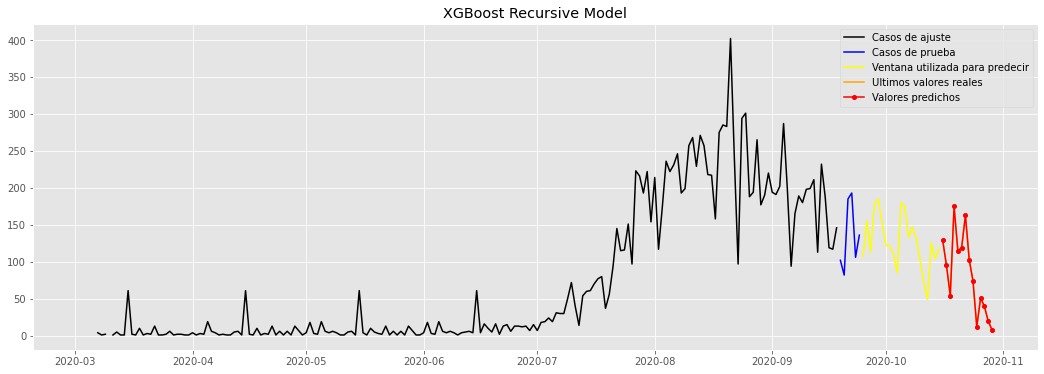

In [29]:
plot_serie_with_next_window_prediction(xgb_rec_test,
                                       final_data_train,
                                       final_data_test,
                                       bga_scaler,
                                       WINDOW_SIZE,
                                       FUTURE_STEPS,
                                       recursive=True,
                                       title='XGBoost Recursive Model')